In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.activations import selu
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import LogCosh,MeanSquaredError,MeanAbsoluteError,MeanSquaredLogarithmicError
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
def plot_history_errors(history, train_key=None, val_key=None, title='Training / validation error'):
    if history is None:
        raise ValueError("history == None: нет истории обучения, график построить нельзя")

    keys = list(history.history.keys())
    print("history keys:", keys)

    # выбор ключей для train
    if train_key is None:
        if 'root_mean_squared_error' in keys:
            train_key = 'root_mean_squared_error'
        elif 'loss' in keys:
            train_key = 'loss'
        else:
            raise ValueError("Не найден ключ для train ошибки в history.history")

    # выбор ключей для val
    if val_key is None:
        if 'val_root_mean_squared_error' in keys:
            val_key = 'val_root_mean_squared_error'
        elif 'val_loss' in keys:
            val_key = 'val_loss'
        else:
            raise ValueError("Не найден ключ для val ошибки в history.history")

    train_err = history.history[train_key]
    val_err   = history.history[val_key]

    # --- отдельный график train ---
    plt.figure(figsize=(8, 4))
    plt.plot(train_err, color='black')
    plt.xlabel('epoch')
    plt.ylabel('error')
    plt.title(f'{title} - train')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- отдельный график test/val ---
    plt.figure(figsize=(8, 4))
    plt.plot(val_err, color='gray')
    plt.xlabel('epoch')
    plt.ylabel('error')
    plt.title(f'{title} - test')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [3]:
data = pd.read_csv('bitcoin_2017_to_2023.csv',nrows=200000)

In [4]:
features = ['timestamp', 'open', 'high', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp'] = data['timestamp'].astype('int64')
#data['timestamp'] = pd.to_datetime(data['timestamp'])
# секунды от эпохи
#data['timestamp'] = data['timestamp'].view('int64') // 10**9   # или // 10**3 для миллисекунд
#data['timestamp'] = data['timestamp'] / 1e6                    # просто уменьшаем масштаб

X = data[features]
y = data['low']

# Разделение на первые 160000 для train и последние 40000 для test
train_size = 160000
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:train_size + 40000]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:train_size + 40000]
min_date_test = pd.Timestamp(X_test['timestamp'].min(), unit='ns')
max_date_test = pd.Timestamp(X_test['timestamp'].max(), unit='ns')

print(f"X_test минимальная дата: {min_date_test}")
print(f"X_test максимальная дата: {max_date_test}")

X_test минимальная дата: 2023-03-15 14:40:00
X_test максимальная дата: 2023-04-12 10:39:00


In [ ]:
features_num = ['open', 'high', 'close', 'volume',
                'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

# Сохраняем данные БЕЗ timestamp в другую переменную
#data_num = data.drop(['timestamp'], axis=1)

# Проверяем, что остались только числовые признаки
print("Колонки в data_num:")
print(data_num.columns.tolist())

# Проверяем типы данных
print("\nDtypes в data_num:")
print(data_num[features_num].dtypes)

# Продолжаем обучение с data_num (оригинальный data сохранен)
X = data_num[features_num].astype('float32')
y = data_num['low'].astype('float32')

train_size = 160000
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:train_size + 40000]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:train_size + 40000]

print("\nX_train dtypes (финальные):")
print(X_train.dtypes)
print(f"X_train shape: {X_train.shape}")
print(f"Память X_train: {X_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Колонки в data_num:
['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

Dtypes в data_num:
open                            float64
high                            float64
close                           float64
volume                          float64
quote_asset_volume              float64
number_of_trades                  int64
taker_buy_base_asset_volume     float64
taker_buy_quote_asset_volume    float64
dtype: object

X_train dtypes (финальные):
open                            float32
high                            float32
close                           float32
volume                          float32
quote_asset_volume              float32
number_of_trades                float32
taker_buy_base_asset_volume     float32
taker_buy_quote_asset_volume    float32
dtype: object
X_train shape: (160000, 8)
Память X_train: 4.88 MB


In [5]:
model_path = 'best_model.keras'
if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)

    # Вывод краткой информации о модели
    print(model.summary())              # структура модели
    print("Оценка на тесте:")
    #eval_res = model.evaluate(X_test, y_test, verbose=0)
    #print("loss =", eval_res[0])
    #if len(eval_res) > 1:
        #print("RMSE =", eval_res[1])

else:
    print("Обучаем новую модель...")
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.17),
        Dense(16, activation='relu'),
        Dropout(0.17),
        Dense(1)
    ])

    model.compile(
        optimizer=Nadam(),
        loss=LogCosh(),
        metrics=[RootMeanSquaredError()]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=488,
        batch_size=216,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

Загружаем существующую обученную модель...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,302 (5.09 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 869 (3.40 KB)

None
Оценка на тесте:


slice_df shape (из X_test): (40000, 10)


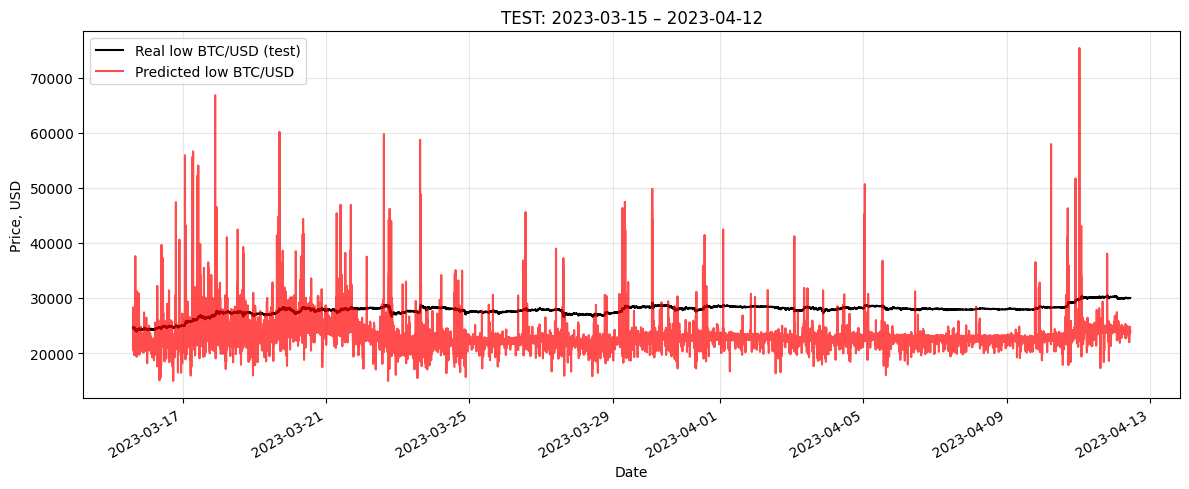

Тестовая выборка: 2023-03-15 14:40:00 – 2023-04-12 10:39:00


In [10]:
slice_df = data.iloc[train_size:train_size + 40000].copy()
print("slice_df shape (из X_test):", slice_df.shape)


features_num = ['open', 'high', 'close', 'volume',
                'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

slice_X = X_test[features_num].astype('float32').to_numpy()
y_pred = model.predict(slice_X, batch_size=256, verbose=0).flatten()


dates = pd.to_datetime(slice_df['timestamp'])
y_real = y_test.to_numpy()

start_date = dates.min()
end_date = dates.max()

import matplotlib.dates as mdates

plt.figure(figsize=(12, 5))
plt.plot(dates, y_real, label='Real low BTC/USD (test)', color='black')
plt.plot(dates, y_pred, label='Predicted low BTC/USD', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price, USD')
plt.title(f'TEST: {start_date.date()} – {end_date.date()}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Тестовая выборка: {start_date} – {end_date}")


In [ ]:
model_path = 'best_model_2.keras'
history = None  # по умолчанию истории нет

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
    print(model.summary())              # структура модели
    print("Оценка на тесте:")
    #eval_res = model.evaluate(X_test, y_test, verbose=0)
    #print("loss =", eval_res[0])
    #if len(eval_res) > 1:
        #print("RMSE =", eval_res[1])
else:
    print("Обучаем новую модель...")
    model = Sequential([
        Dense(26, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.19),
        Dense(26, activation='relu'),
        Dropout(0.19),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Nadam(),
        loss=LogCosh(),
        metrics=[RootMeanSquaredError()]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=310,
        batch_size=100,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

if history is not None:
    plot_history_errors(history, title='MSE model, RMSE over epochs')
else:
    print("Модель загружена из файла: history нет, график по эпохам построить нельзя.")

Загружаем существующую обученную модель...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 26)             │           234 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26)             │           702 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,892 (11.30 KB)

 Trainable params: 963 (3.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,929 (7.54 KB)

None
Оценка на тесте:
Модель загружена из файла: history нет, график по эпохам построить нельзя.


slice_df shape (из X_test): (40000, 10)


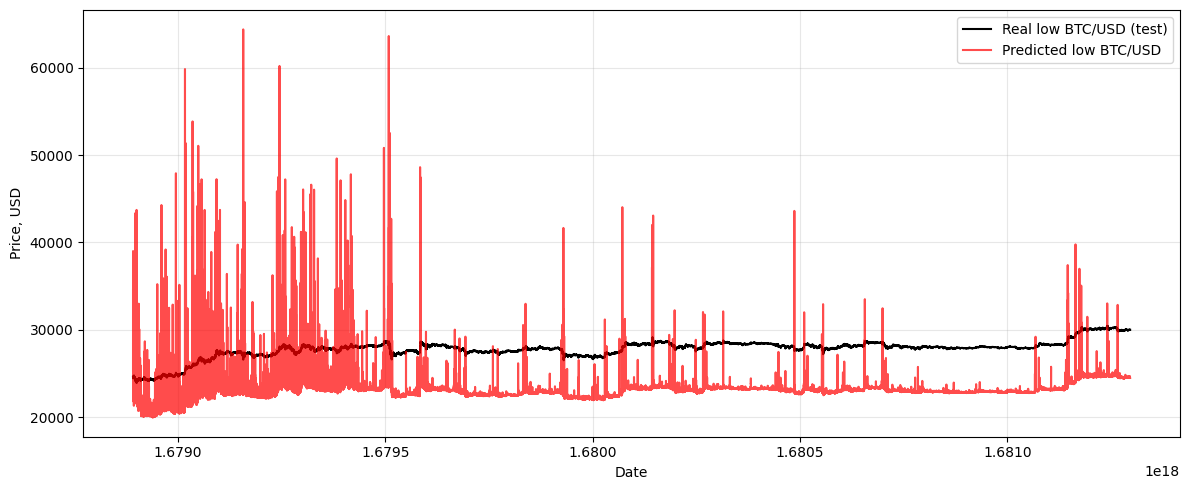

Тестовая выборка: 2023-03-15 14:40:00 – 2023-04-12 10:39:00


In [ ]:

slice_df = data.iloc[train_size:train_size + 40000].copy()

print("slice_df shape (из X_test):", slice_df.shape)

# 2. Числовые фичи БЕЗ timestamp (8 фич как в обучении)
features_num = ['open', 'high', 'close', 'volume',
                'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

# X_test уже готов для предсказаний
slice_X = X_test[features_num].astype('float32').to_numpy()
y_pred = model.predict(slice_X, batch_size=256, verbose=0).flatten()

dates = slice_df['timestamp']  # Берем из data (datetime), НЕ из X_test
y_real = y_test.to_numpy()

# Конвертируем обратно в datetime для .date()
start_date = pd.to_datetime(dates.min(), unit='ns')
end_date = pd.to_datetime(dates.max(), unit='ns')

plt.figure(figsize=(12, 5))
plt.plot(dates, y_real, label='Real low BTC/USD (test)', color='black')
plt.plot(dates, y_pred, label='Predicted low BTC/USD', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price, USD')

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Тестовая выборка: {start_date} – {end_date}")



In [ ]:
model_path = 'best_model_3.keras'
history = None

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
    print(model.summary())              # структура модели
    print("Оценка на тесте:")
    #eval_res = model.evaluate(X_test, y_test, verbose=0)
    #print("loss =", eval_res[0])
    #if len(eval_res) > 1:
        #print("RMSE =", eval_res[1])
else:
    print("Обучаем новую модель...")
    model = Sequential([
        Dense(6, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.03),
        Dense(6, activation='relu'),
        Dropout(0.03),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Nadam(),
        loss=MeanSquaredError(),
        metrics=[RootMeanSquaredError()]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=381,
        batch_size=80,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

if history is not None:
    plot_history_errors(history, title='MSE model, RMSE over epochs')
else:
    print("Модель загружена из файла: history нет, график по эпохам построить нельзя.")


Загружаем существующую обученную модель...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312 (1.22 KB)

 Trainable params: 103 (412.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 209 (840.00 B)

None
Оценка на тесте:
Модель загружена из файла: history нет, график по эпохам построить нельзя.


slice_df shape (из X_test): (40000, 10)


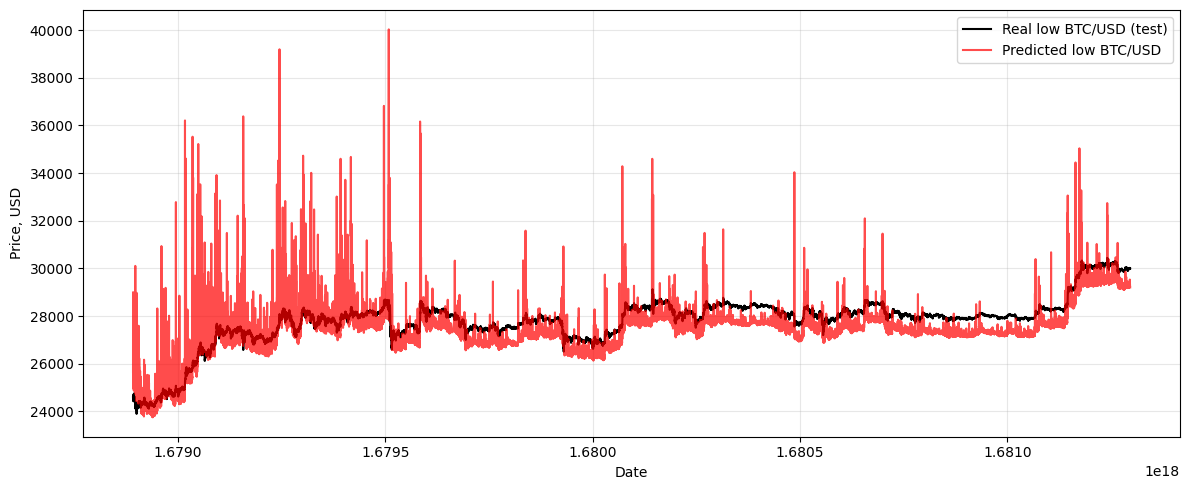

Тестовая выборка: 2023-03-15 14:40:00 – 2023-04-12 10:39:00


In [ ]:

slice_df = data.iloc[train_size:train_size + 40000].copy()

print("slice_df shape (из X_test):", slice_df.shape)

# 2. Числовые фичи БЕЗ timestamp (8 фич как в обучении)
features_num = ['open', 'high', 'close', 'volume',
                'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

# X_test уже готов для предсказаний
slice_X = X_test[features_num].astype('float32').to_numpy()
y_pred = model.predict(slice_X, batch_size=256, verbose=0).flatten()

dates = slice_df['timestamp']  # Берем из data (datetime), НЕ из X_test
y_real = y_test.to_numpy()

# Конвертируем обратно в datetime для .date()
start_date = pd.to_datetime(dates.min(), unit='ns')
end_date = pd.to_datetime(dates.max(), unit='ns')

plt.figure(figsize=(12, 5))
plt.plot(dates, y_real, label='Real low BTC/USD (test)', color='black')
plt.plot(dates, y_pred, label='Predicted low BTC/USD', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price, USD')

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Тестовая выборка: {start_date} – {end_date}")



Обучаем новую модель...
Epoch 1/373


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1993/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15983709184.0000 - root_mean_squared_error: 112278.0469
Epoch 1: val_root_mean_squared_error improved from inf to 22780.23438, saving model to best_model_4.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 15938162688.0000 - root_mean_squared_error: 112100.0625 - val_loss: 518939072.0000 - val_root_mean_squared_error: 22780.2344
Epoch 2/373
1984/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 541467840.0000 - root_mean_squared_error: 23119.8145
Epoch 2: val_root_mean_squared_error improved from 22780.23438 to 8892.01855, saving model to best_model_4.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 540239424.0000 - root_mean_squared_error: 23092.6445 - val_loss: 79067992.0000 - val_root_mean_squared_error: 8892.0186
Epoch 3/373
1994/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 212689712.0000 - root_mean_squared_error: 14501.5830
Epoch 3: val_root_mean_squared_error improved from 8892.01855 to 7451.11475, saving model to be

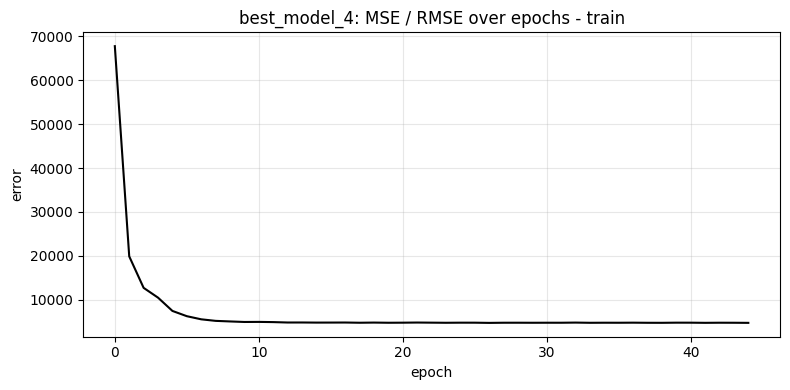

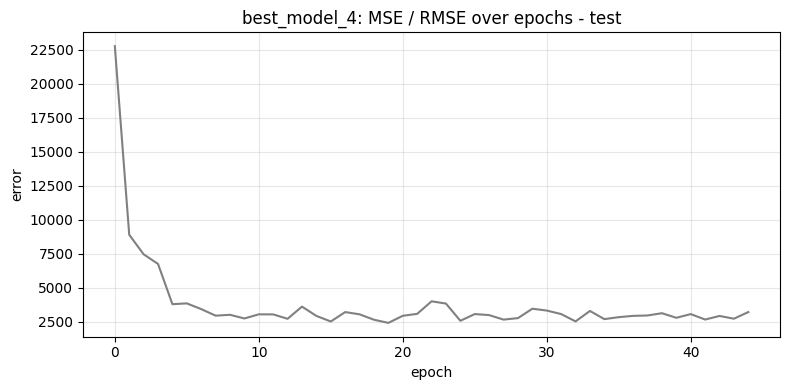

In [ ]:
model_path = 'best_model_4.keras'
history = None

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
    print(model.summary())              # структура модели
    print("Оценка на тесте:")
    eval_res = model.evaluate(X_test, y_test, verbose=0)
    print("loss =", eval_res[0])
    if len(eval_res) > 1:
        print("RMSE =", eval_res[1])
else:
    print("Обучаем новую модель...")
    model = Sequential([
        Dense(14, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.08),
        Dense(14, activation='relu'),
        Dropout(0.08),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Nadam(),
        loss=MeanSquaredError(),
        metrics=[RootMeanSquaredError()]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=373,
        batch_size=80,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

# Вызов функции построения графика
if history is not None:
    plot_history_errors(history, title='best_model_4: MSE / RMSE over epochs')
else:
    print("Модель загружена из файла: history отсутствует, "
          "поэтому график обучения по эпохам в этом запуске построить нельзя.")


Обучаем новую модель...
Epoch 1/494


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1443/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28540.2773 - root_mean_squared_error: 28587.8887
Epoch 1: val_root_mean_squared_error improved from inf to 27826.30664, saving model to best_model_5.keras
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 28540.2168 - root_mean_squared_error: 28587.8281 - val_loss: 27806.7012 - val_root_mean_squared_error: 27826.3066
Epoch 2/494
1438/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28537.2070 - root_mean_squared_error: 28584.7344
Epoch 2: val_root_mean_squared_error improved from 27826.30664 to 27826.26367, saving model to best_model_5.keras
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 28537.1699 - root_mean_squared_error: 28584.6973 - val_loss: 27806.6602 - val_root_mean_squared_error: 27826.2637
Epoch 3/494
1437/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28533.8242 - root_mean_squared_error: 28581.6680
Epoch 3: val_root_mean_squared_error improved from 27826.26367 to 27826.20703, saving model to best_model_5.keras
1455/1455 ━━

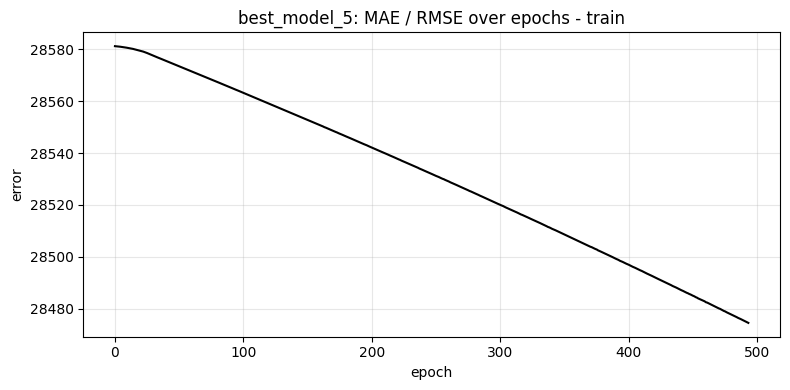

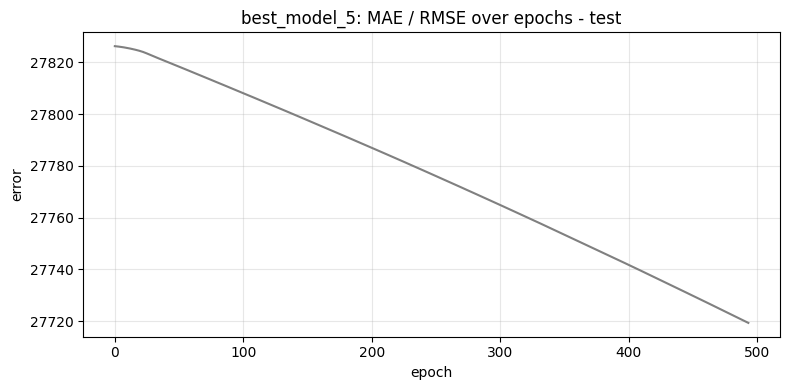

In [ ]:
model_path = 'best_model_5.keras'
history = None

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
else:
    print("Обучаем новую модель...")
    model = Sequential([
        Dense(5, activation='tanh', input_shape=(X_train.shape[1],)),
        Dropout(0.11),
        Dense(5, activation='tanh'),
        Dropout(0.11),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer='Adadelta',
        loss=MeanAbsoluteError(),
        metrics=[RootMeanSquaredError()]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=494,
        batch_size=110,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

# Построение графика, если было обучение в этом запуске
if history is not None:
    plot_history_errors(history, title='best_model_5: MAE / RMSE over epochs')
else:
    print("Модель загружена из файла: history отсутствует, "
          "поэтому график обучения по эпохам в этом запуске построить нельзя.")


Обучаем новую модель...
Epoch 1/382


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1106/1112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28518.2891 - root_mean_squared_error: 28566.5938
Epoch 1: val_root_mean_squared_error improved from inf to 27784.41406, saving model to best_model_6.keras
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 28518.2305 - root_mean_squared_error: 28566.5371 - val_loss: 27764.0898 - val_root_mean_squared_error: 27784.4141
Epoch 2/382
1096/1112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28479.9004 - root_mean_squared_error: 28528.3809
Epoch 2: val_root_mean_squared_error improved from 27784.41406 to 27749.73242, saving model to best_model_6.keras
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 28479.8027 - root_mean_squared_error: 28528.2832 - val_loss: 27729.3789 - val_root_mean_squared_error: 27749.7324
Epoch 3/382
1085/1112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28448.5996 - root_mean_squared_error: 28496.9727
Epoch 3: val_root_mean_squared_error improved from 27749.73242 to 27715.22266, saving model to best_model_6.keras
1112/1112 ━━

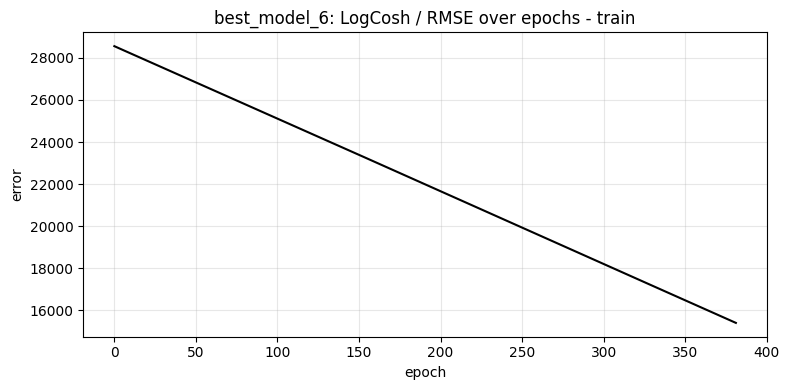

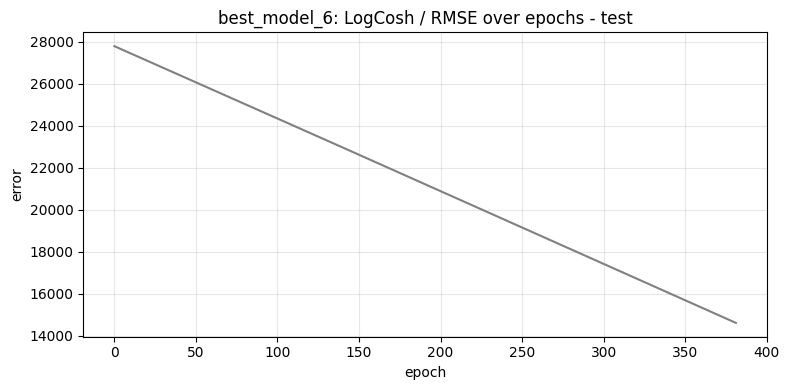

In [ ]:
model_path = 'best_model_6.keras'
history = None

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
else:
    print("Обучаем новую модель...")
    model = Sequential([
        Dense(30, activation='tanh', input_shape=(X_train.shape[1],)),
        Dense(30, activation='tanh'),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Nadam(),
        loss=LogCosh(),
        metrics=[RootMeanSquaredError()]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=382,
        batch_size=144,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

# построение графика, если модель обучалась в этом запуске
if history is not None:
    plot_history_errors(history, title='best_model_6: LogCosh / RMSE over epochs')
else:
    print("Модель загружена из файла: history отсутствует, "
          "поэтому график обучения по эпохам в этом запуске построить нельзя.")


Обучаем новую модель...
Epoch 1/455


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1283/1301 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24222.1113 - root_mean_squared_error: 84514.3750
Epoch 1: val_root_mean_squared_error improved from inf to 4364.46387, saving model to best_model_7.keras
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 24038.5840 - root_mean_squared_error: 84029.9844 - val_loss: 2392.4375 - val_root_mean_squared_error: 4364.4639
Epoch 2/455
1285/1301 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3333.4512 - root_mean_squared_error: 9294.1143
Epoch 2: val_root_mean_squared_error improved from 4364.46387 to 2832.97168, saving model to best_model_7.keras
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3329.2139 - root_mean_squared_error: 9284.6367 - val_loss: 1879.5184 - val_root_mean_squared_error: 2832.9717
Epoch 3/455
1296/1301 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2336.8660 - root_mean_squared_error: 7923.1489
Epoch 3: val_root_mean_squared_error did not improve from 2832.97168
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2336.4390 - root_me

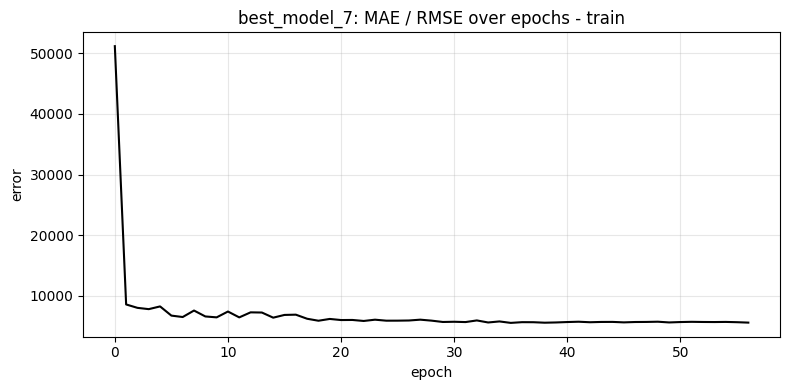

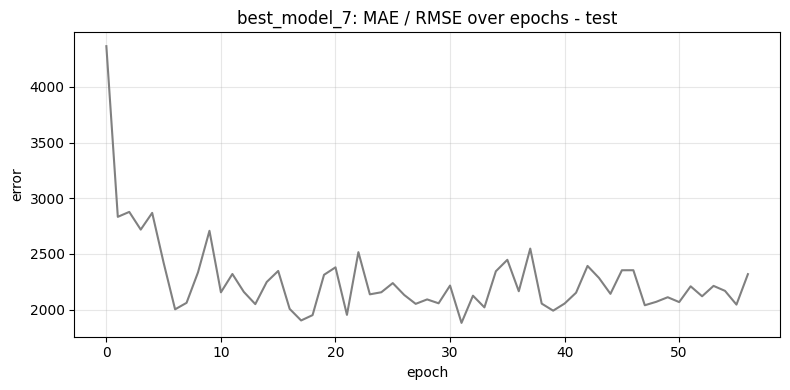

In [ ]:
model_path = 'best_model_7.keras'
history = None

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
else:
    print("Обучаем новую модель...")
    model = Sequential([
        Dense(12, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.04),
        Dense(12, activation='relu'),
        Dropout(0.04),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Nadam(),
        loss=MeanAbsoluteError(),      # MAE
        metrics=[RootMeanSquaredError()]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=455,
        batch_size=123,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

# построение графика, если модель обучалась в этом запуске
if history is not None:
    plot_history_errors(history, title='best_model_7: MAE / RMSE over epochs')
else:
    print("Модель загружена из файла: history отсутствует, "
          "поэтому график обучения по эпохам в этом запуске построить нельзя.")


Обучаем новую модель...
Epoch 1/231


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1379/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2689068800.0000 - root_mean_squared_error: 50057.1914
Epoch 1: val_root_mean_squared_error improved from inf to 33552.64062, saving model to best_model_8.keras
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 2687149824.0000 - root_mean_squared_error: 50038.1836 - val_loss: 1125779712.0000 - val_root_mean_squared_error: 33552.6406
Epoch 2/231
1379/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 247796256.0000 - root_mean_squared_error: 15661.9629
Epoch 2: val_root_mean_squared_error did not improve from 33552.64062
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 247709888.0000 - root_mean_squared_error: 15659.1465 - val_loss: 4275886080.0000 - val_root_mean_squared_error: 65390.2617
Epoch 3/231
1365/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104087792.0000 - root_mean_squared_error: 10146.6680
Epoch 3: val_root_mean_squared_error improved from 33552.64062 to 4521.02930, saving model to best_model_8.keras
1380/1380 ━━━━━━━━━━━━━━━

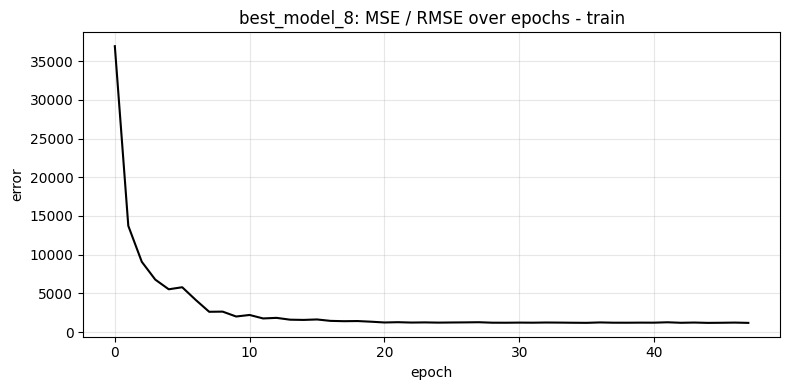

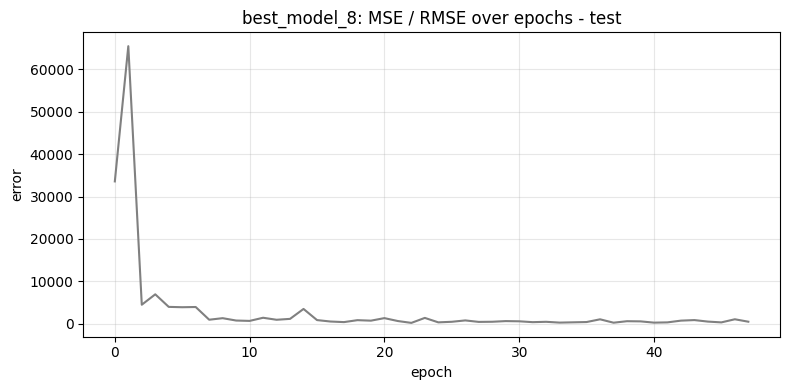

In [ ]:
model_path = 'best_model_8.keras'
history = None

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
else:
    print("Обучаем новую модель...")
    model = Sequential([
        Dense(21, activation='selu', input_shape=(X_train.shape[1],)),
        Dropout(0.01),
        Dense(21, activation='selu'),
        Dropout(0.01),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Nadam(),
        loss=MeanSquaredError(),      # MSE
        metrics=[RootMeanSquaredError()]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=231,
        batch_size=116,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

# построение графика, если модель обучалась в этом запуске
if history is not None:
    plot_history_errors(history, title='best_model_8: MSE / RMSE over epochs')
else:
    print("Модель загружена из файла: history отсутствует, "
          "поэтому график обучения по эпохам в этом запуске построить нельзя.")


Обучаем новую модель...
Epoch 1/486


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1385/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22680.3496 - root_mean_squared_error: 60535.6875
Epoch 1: val_root_mean_squared_error improved from inf to 1557.38611, saving model to best_model_9.keras
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 22606.1387 - root_mean_squared_error: 60418.9688 - val_loss: 1002.5776 - val_root_mean_squared_error: 1557.3861
Epoch 2/486
1381/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2130.7751 - root_mean_squared_error: 7806.8726
Epoch 2: val_root_mean_squared_error did not improve from 1557.38611
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2128.7368 - root_mean_squared_error: 7799.7305 - val_loss: 1867.4202 - val_root_mean_squared_error: 2425.3979
Epoch 3/486
1375/1392 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1592.5084 - root_mean_squared_error: 5809.0020
Epoch 3: val_root_mean_squared_error improved from 1557.38611 to 1345.74597, saving model to best_model_9.keras
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1592.0880 - root_me

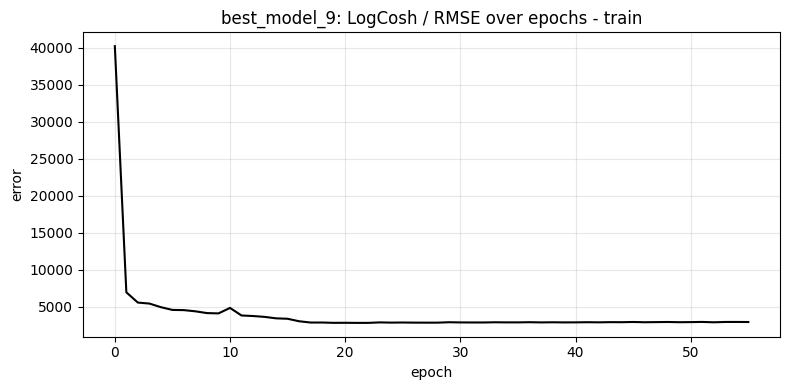

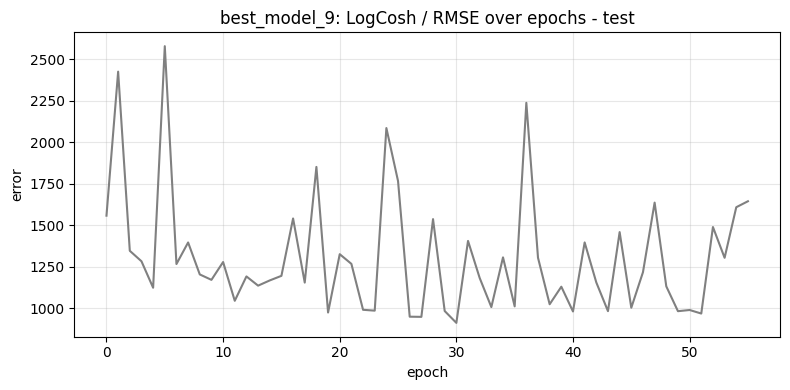

In [ ]:
model_path = 'best_model_9.keras'
history = None

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
else:
    print("Обучаем новую модель...")
    model = Sequential([
        Dense(8, activation='selu', input_shape=(X_train.shape[1],)),
        Dropout(0.02),
        Dense(8, activation='selu'),
        Dropout(0.02),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Nadam(),
        loss=LogCosh(),                 # LogCosh
        metrics=[RootMeanSquaredError()]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=486,
        batch_size=115,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

# построение графика, если модель обучалась в этом запуске
if history is not None:
    plot_history_errors(history, title='best_model_9: LogCosh / RMSE over epochs')
else:
    print("Модель загружена из файла: history отсутствует, "
          "поэтому график обучения по эпохам в этом запуске построить нельзя.")


Обучаем новую модель...
Epoch 1/460


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2235/2254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.8468 - root_mean_squared_error: 28568.4844
Epoch 1: val_root_mean_squared_error improved from inf to 27764.59180, saving model to best_model_10.keras
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 56.7666 - root_mean_squared_error: 28568.2969 - val_loss: 37.3254 - val_root_mean_squared_error: 27764.5918
Epoch 2/460
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.2785 - root_mean_squared_error: 28501.4277
Epoch 2: val_root_mean_squared_error improved from 27764.59180 to 27708.63086, saving model to best_model_10.keras
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 35.2777 - root_mean_squared_error: 28501.4219 - val_loss: 29.9224 - val_root_mean_squared_error: 27708.6309
Epoch 3/460
2245/2254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.9465 - root_mean_squared_error: 28449.8340
Epoch 3: val_root_mean_squared_error improved from 27708.63086 to 27652.58203, saving model to best_model_10.keras
2254/2254 ━━━━━━━━━━━━━━━━━━━

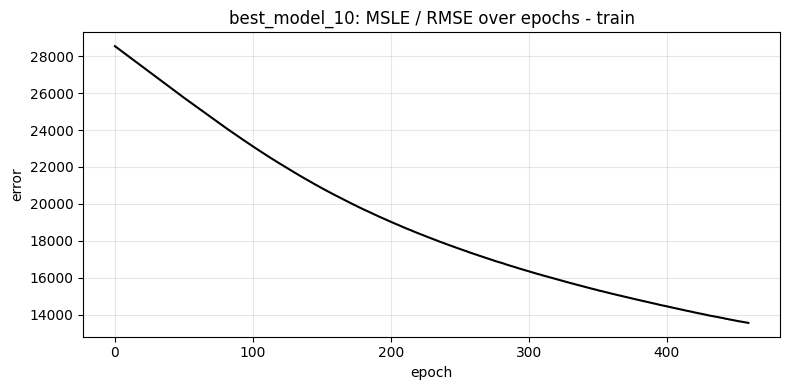

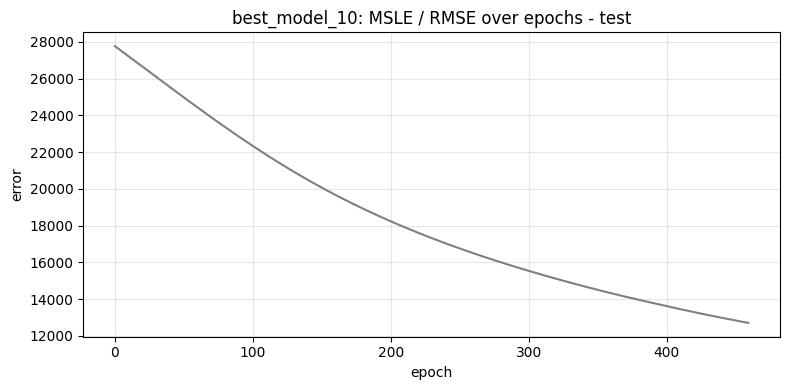

In [ ]:
model_path = 'best_model_10.keras'
history = None

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
else:
    print("Обучаем новую модель...")
    model = Sequential([
        Dense(24, activation='tanh', input_shape=(X_train.shape[1],)),
        Dropout(0.14),
        Dense(24, activation='tanh'),
        Dropout(0.14),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer='RMSprop',
        loss=MeanSquaredLogarithmicError(),
        metrics=[RootMeanSquaredError()]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=460,
        batch_size=71,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

# построение графика, если модель обучалась в этом запуске
if history is not None:
    plot_history_errors(history, title='best_model_10: MSLE / RMSE over epochs')
else:
    print("Модель загружена из файла: history отсутствует, "
          "поэтому график обучения по эпохам в этом запуске построить нельзя.")


/tmp/ipython-input-1908033764.py:8: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  data['timestamp_num'] = data['timestamp'].view('int64')  # наносекунды как int64


slice_df shape: (44561, 11)


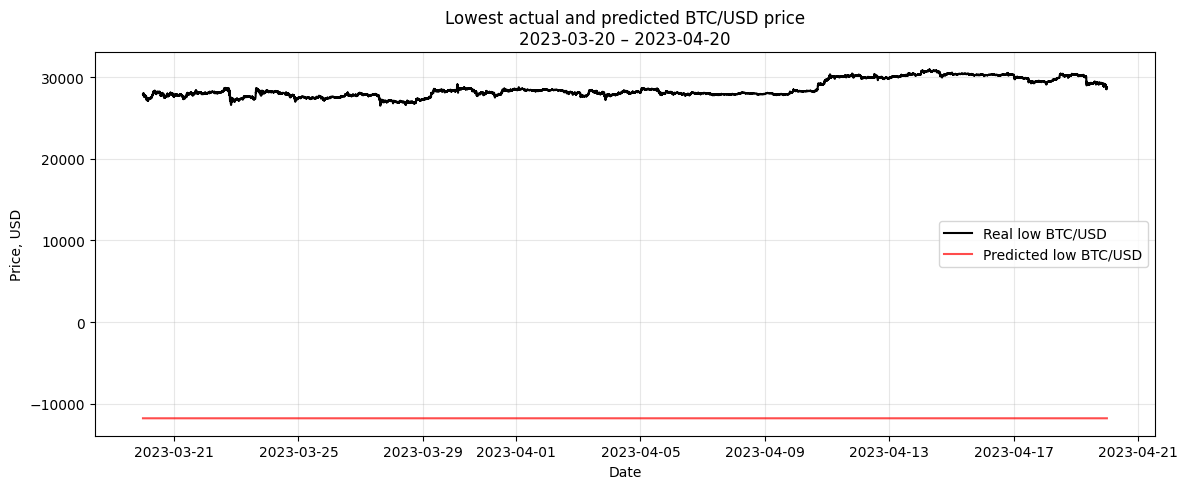

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# исходный data: timestamp уже datetime64
# сделаем числовую копию для модели и оставим datetime для графика
data = data.copy()
data['timestamp_num'] = data['timestamp'].view('int64')  # наносекунды как int64

# 1. Диапазон дат (в рамках 2023-03-15 .. 2023-08-01)
start_date = pd.to_datetime('2023-03-20')
end_date   = pd.to_datetime('2023-04-20')

mask = (data['timestamp'] >= start_date) & (data['timestamp'] <= end_date)
slice_df = data.loc[mask].copy()

print("slice_df shape:", slice_df.shape)
if slice_df.empty:
    raise ValueError("В выбранном диапазоне дат нет данных, поменяй start_date / end_date.")

# 2. Фичи для модели: используем timestamp_num вместо timestamp
features = ['timestamp_num', 'open', 'high', 'low', 'volume',
            'quote_asset_volume', 'number_of_trades',
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

slice_X = slice_df[features].astype('float32').to_numpy()

# 3. Прогноз (через model(...), теперь все фичи числовые)
y_pred = model(slice_X, training=False).numpy().flatten()

# 4. Реальные минимальные цены и даты
dates  = slice_df['timestamp']              # datetime для оси X
y_real = slice_df['low'].to_numpy()

# 5. График
plt.figure(figsize=(12, 5))
plt.plot(dates, y_real, label='Real low BTC/USD', color='black')
plt.plot(dates, y_pred, label='Predicted low BTC/USD', color='red', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Price, USD')
plt.title(f'Lowest actual and predicted BTC/USD price\n{start_date.date()} – {end_date.date()}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(data['timestamp'].min(), data['timestamp'].max())

2023-03-15 14:40:00 2023-08-01 13:19:00
